In [800]:
import torch
import torch.nn as nn
import corner
import numpy as np
import pylab as plt

import pycbc
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

import swyft

DEVICE = 'cuda'

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model

In [801]:
prior_conf = {
    "D": ["uniform", 50, 1000.],
    "M1": ["uniform", 10.0, 100.001],
    "M2": ["uniform", 10.0, 100.001],
    #"I": ["uniform", 0.0, 0.001],
    #"RA": ["uniform", 0.0, 0.001],
    #"DEC": ["uniform", 0.0, 0.001],
    #"pol": ["uniform", 0.0, 0.001]
}

In [891]:
def model(par):
    hp, hc = get_td_waveform(delta_t = 0.001, f_lower = 20.0, f_ref = 20.0, approximant = "IMRPhenomPv2",
                            distance = par['D'],
                            mass1 = par['M1'],
                            mass2 = par['M2'],
                            inclination = 0., #par['I']
                            )
    signal_h1 = det_h1.project_wave(hp, hc, 0, 0, 0)*1e21
    #signal_h1 = det_h1.project_wave(hp, hc, float(0*par['RA']), float(0*par['DEC']), float(0*par['pol']))*1e20
    #signal_l1 = det_l1.project_wave(hp, hc, float(0*par['RA']), float(0*par['DEC']), float(0*par['pol']))*1e20
    
    return dict(h1=np.array(signal_h1)[-1000:])#, l1=np.array(signal_l1)[-1000:])

def noise(obs, par):
    return dict(h1 = obs['h1'] + np.random.randn(1000)*1e-2)

### Storage

In [892]:
cache = swyft.MemoryCache(par_names = prior_conf.keys(), obs_shapes = {"h1": (1000,)})

Creating new cache.


### Reference model

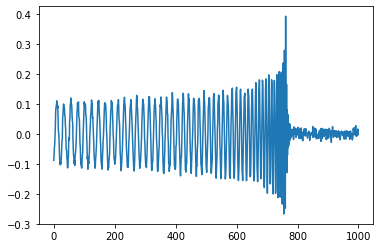

In [893]:
par0 = dict(D=350., M1=10., M2=10.)
obs0 = noise(model(par0), par0)
plt.plot(obs0['h1'])
#plt.plot(obs0['l1'])

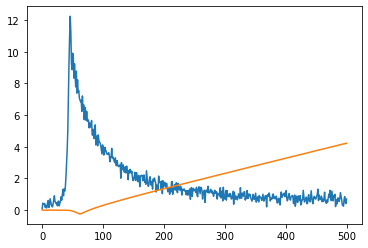

In [915]:
def obs_trans(obs):
    h1 = obs['h1']
    fh1 = np.fft.fft(h1)[:500]
    phase = np.angle(fh1)
    phase = np.unwrap(phase)
    magnitude = np.abs(fh1)
    phase = phase / phase.mean() * magnitude.mean()
    h1 = np.stack([magnitude, phase])
    return dict(h1=h1)

plt.plot(obs_trans(obs0)['h1'][0])
plt.plot(obs_trans(obs0)['h1'][1])

### Head network

In [981]:
class Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = nn.Linear(2000, 1)
        self.c1 = nn.Conv1d(2, 5, 5)
        self.c2 = nn.Conv1d(5, 10, 5)
        self.c3 = nn.Conv1d(10, 20, 5)
        self.c4 = nn.Conv1d(20, 40, 5)
        self.mp = nn.MaxPool1d(3)
        
    def forward(self, obs):
        x = obs['h1']
        batch = x.shape[:-2]
        if len(batch) == 0:
            x = x.unsqueeze(0)
        x = self.c1(x)
        x = self.mp(x)
        x = self.c2(x)
        x = self.mp(x)
        x = self.c3(x)
        x = self.mp(x)
        x = self.c4(x)
        x = self.mp(x)
        x = x.view(*batch, -1)
        return x

### SWYFT!

In [1016]:
s = swyft.SWYFT(model, noise, prior_conf, cache, device = DEVICE)

In [1017]:
s.round(Nsim = 30000, head = Head, obs_trans = obs_trans, par_trans = par_trans)

Round: 1


Simulate:   0%|          | 6/20015 [00:00<06:04, 54.84it/s]

Adding 20015 new samples. Run simulator!


Simulate: 100%|██████████| 20015/20015 [04:59<00:00, 66.80it/s]


Number of features from head network: 160
Number of parameters to estimate: 3
Maximum posterior dimensionality: 1
Start training
LR iteration 0
Validation loss: 2058.7606422901154
Validation loss: 1878.3791353702545
Validation loss: 1823.5962193012238
Validation loss: 1567.765417098999
Validation loss: 1470.4874079227448
Validation loss: 1379.637968659401
Validation loss: 1203.372681081295
Validation loss: 1403.6691333055496
Total epochs: 8
LR iteration 1
Validation loss: 884.5379745364189
Validation loss: 838.9276139736176
Validation loss: 806.7978386282921
Validation loss: 787.556374847889
Validation loss: 781.3445819616318
Validation loss: 797.6471699476242
Total epochs: 6


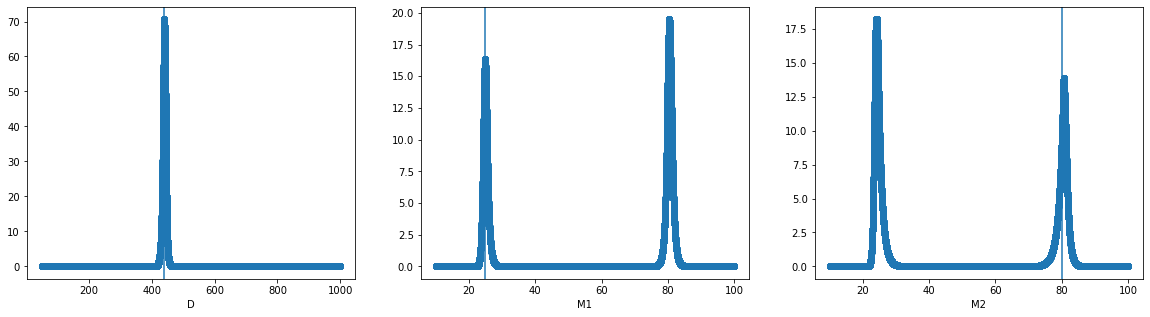

In [1031]:
par0 = dict(D=440., M1=25., M2=80.)
obs0 = noise(model(par0), par0)
pars, lnL = s.lnL(obs0)
plt.figure(figsize=(20, 5))
for i, tag in enumerate(prior_conf):
    plt.subplot(1, 3, i+1)
    plt.scatter(pars[tag], np.exp(lnL[(tag,)]))
    plt.axvline(par0[tag])
    plt.xlabel(tag)
#plt.gca().set_yscale('log')